In [2]:
%matplotlib inline
import matplotlib.pyplot as plt

In [13]:
import xarray as xr
import pandas as pd

In [4]:
diff = xr.open_dataset("I80diffs.nc")

In [5]:
diff

<xarray.Dataset>
Dimensions:    (Abs_PM: 164, day: 21, minute: 288)
Coordinates:
  * minute     (minute) int32 0 5 10 15 20 25 30 35 40 45 50 55 60 65 70 75 ...
  * Abs_PM     (Abs_PM) float64 3.3 4.48 4.59 4.7 4.8 4.91 5.09 5.19 5.28 ...
  * day        (day) |S14 b'2016_04_01.csv' b'2016_04_04.csv' ...
Data variables:
    occupancy  (day, minute, Abs_PM) float64 0.0026 0.0031 0.002 0.0023 ...

In [6]:
d = diff['occupancy']

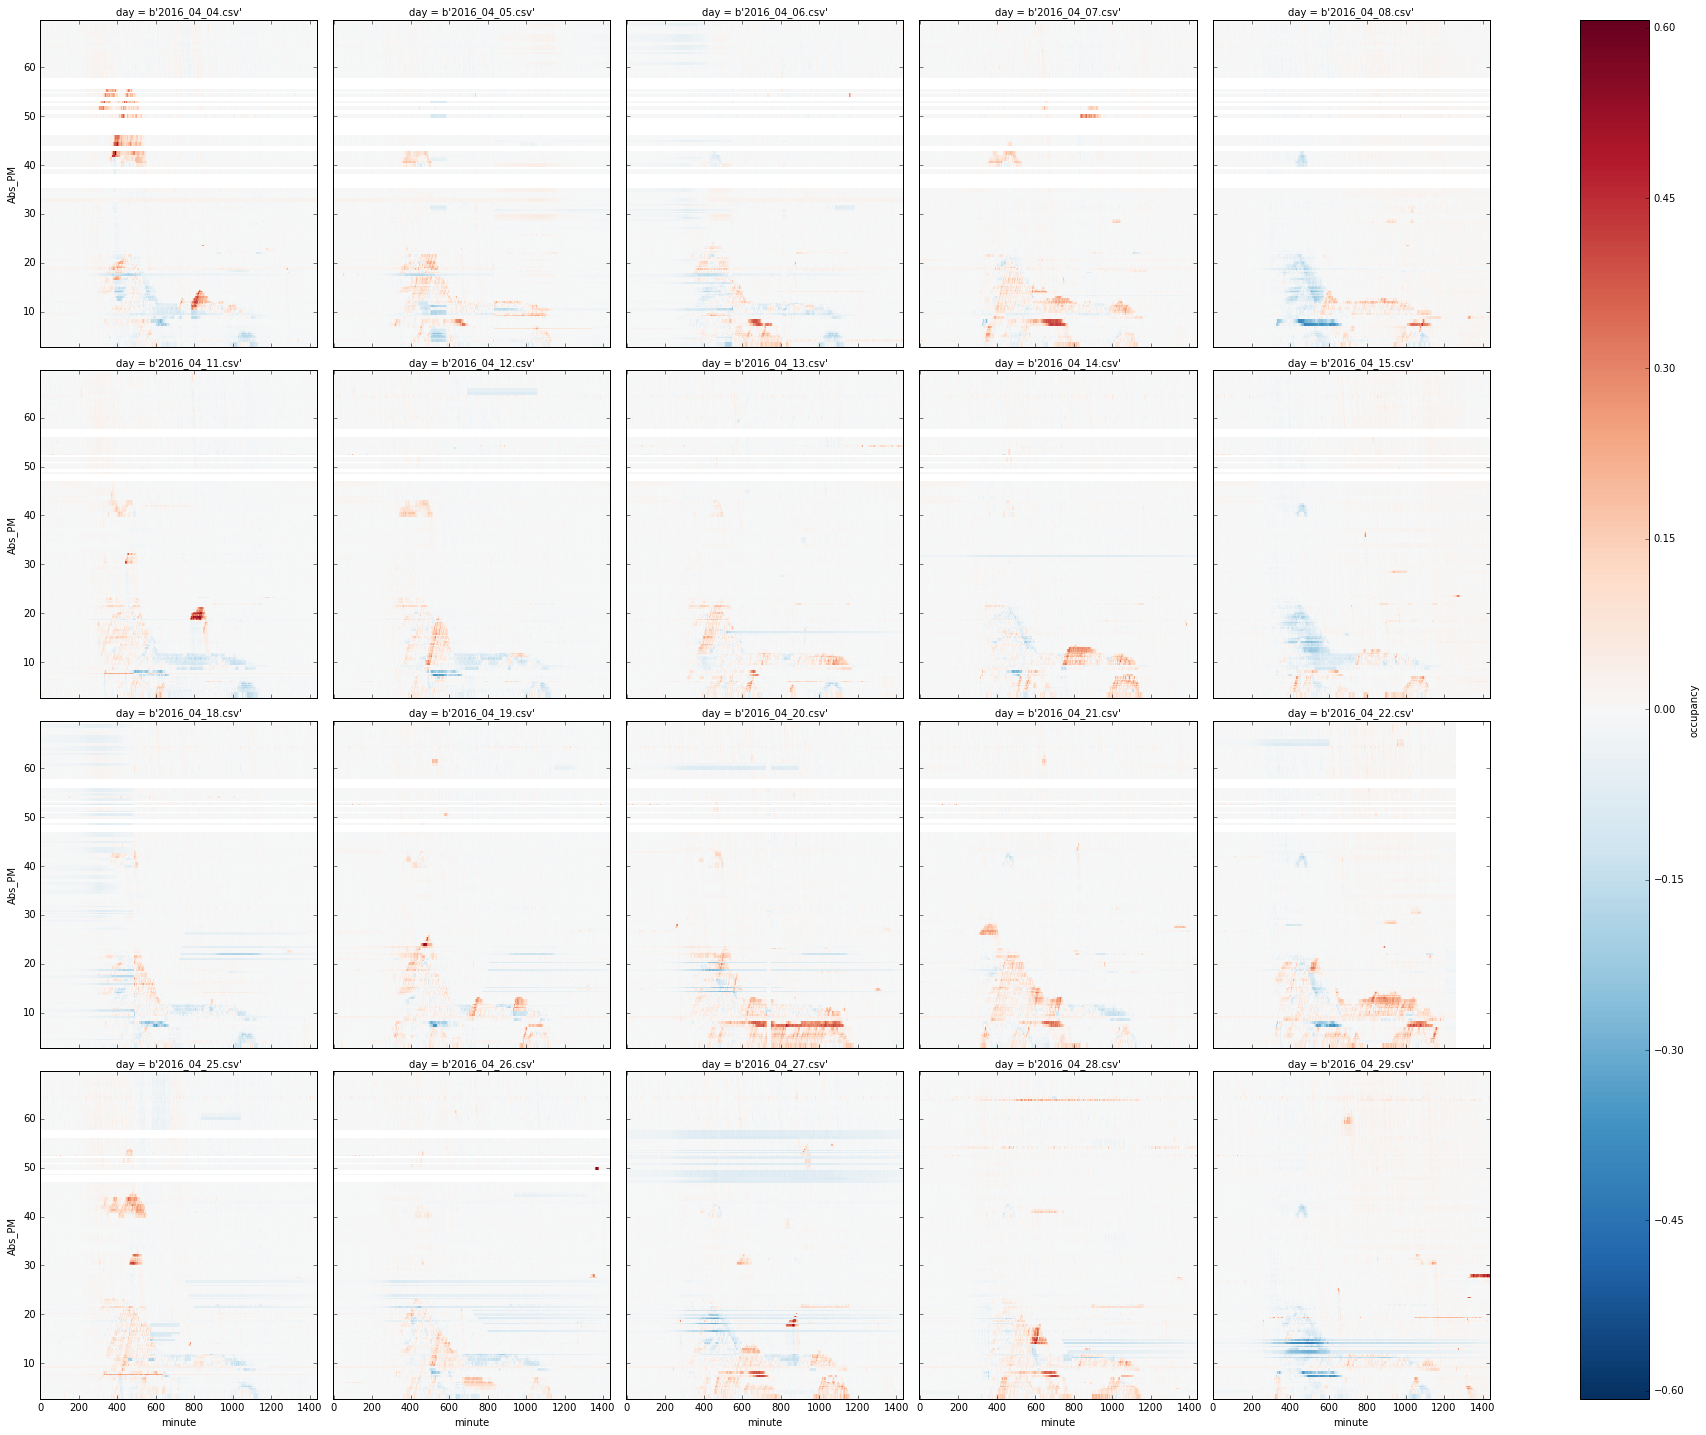

In [11]:
# Drop the first day to make a plot aligned on weekdays
d[1:, :, :].plot.pcolormesh(x = "minute", y = "Abs_PM",
                            col = "day", col_wrap = 5, size = 5, aspect = 1)

plt.savefig("diffs.png")

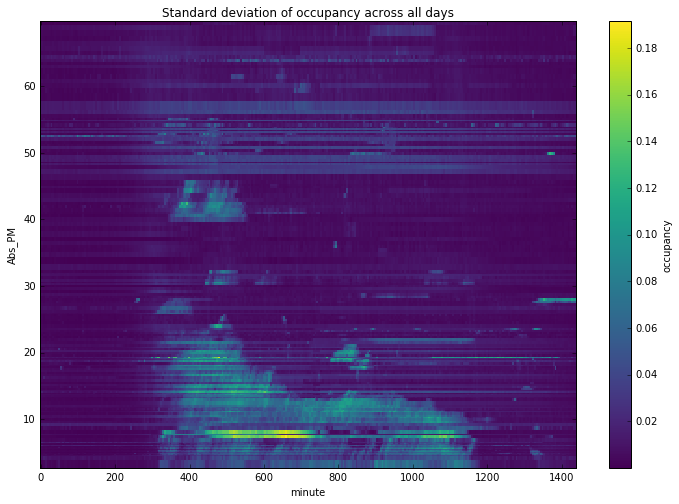

In [135]:
dsd = d.std("day")

plt.figure(figsize = (12, 8))
dsd.plot(x = "minute", y = "Abs_PM")
plt.title("Standard deviation of occupancy across all days")

The brighter colors on this plot correspond to times and locations where occupancy is highly variable.

We could add linear scaling such that areas of variable occupancy have low weight. `occupancy` loses the meaning, but it's still useful.

In [136]:
dsd_weight = 10 - 50 * dsd

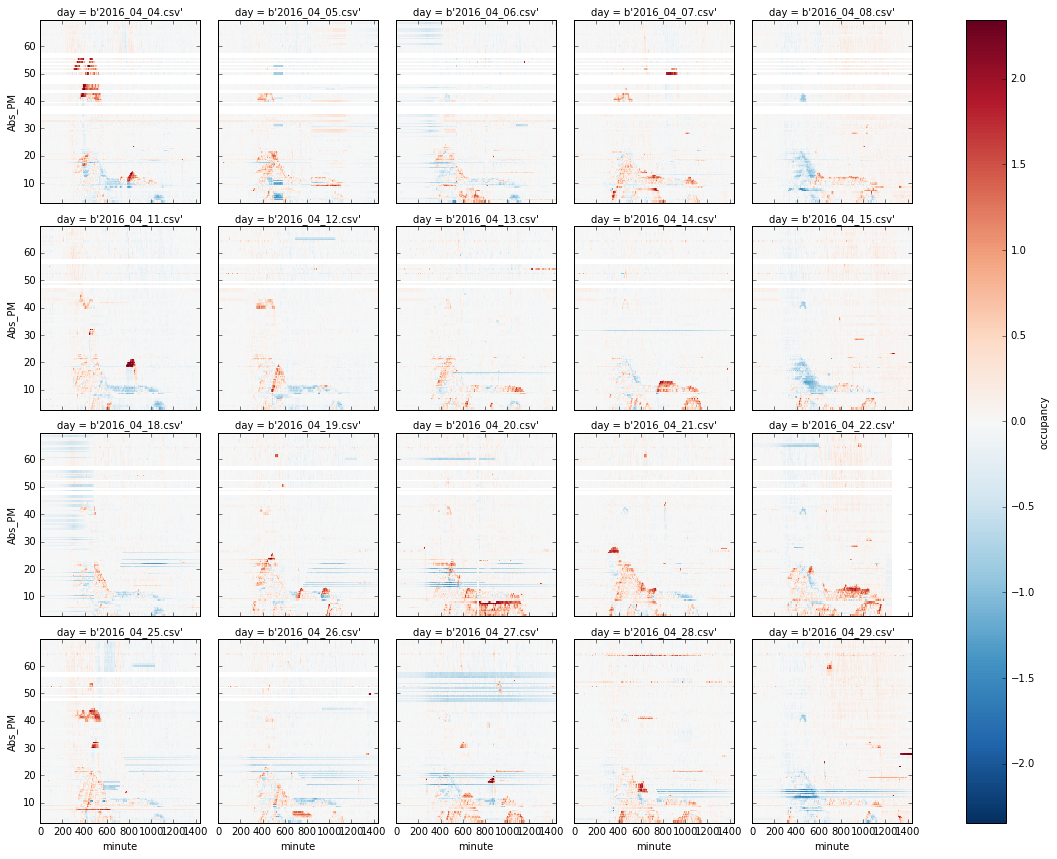

In [137]:
d2 = d * dsd_weight

d2[1:, :, :].plot.pcolormesh(x = "minute", y = "Abs_PM",
                            col = "day", col_wrap = 5, size = 3, aspect = 1)


The 29th looks like some interesting things happened. Let's plot the corresponding incidents on the density.

In [95]:
chp = pd.read_csv("chp_incidents_80W.csv")

chp["Abs_PM"] = (chp
                 .iloc[:, 17]
                 .astype("float")
                 )

chp["dt"] = chp.iloc[:, 3].str.extract("([0-9]{2}/[0-9]{2})/")

/home/clark/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:8: FutureWarning: currently extract(expand=None) means expand=False (return Index/Series/DataFrame) but in a future version of pandas this will be changed to expand=True (return DataFrame)


The 17th index is absolute postmile

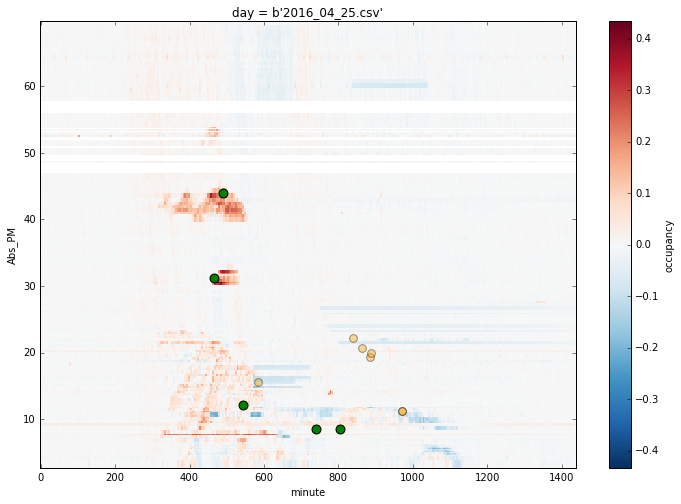

In [141]:
dc = d.sel(day = b"2016_04_25.csv")
#dc = d2.sel(day = b"2016_04_25.csv")
dt_pick = dt == "04/25"

plt.figure(figsize = (12, 8))
dc.plot(x = "minute", y = "Abs_PM")

rows = chp[dt_pick]

# Add points for incidents
plt.scatter(rows["minute"], rows["Abs_PM"], c="orange", s=60, alpha=0.4)

cl = rows[rows["collision"]]
plt.scatter(cl["minute"], cl["Abs_PM"], c="green", s=80)

Now lets see if we can write the thresholding algorithm to describe these areas numerically. For the image above I expect to get at least the ones around (450, 30), (450, 45).

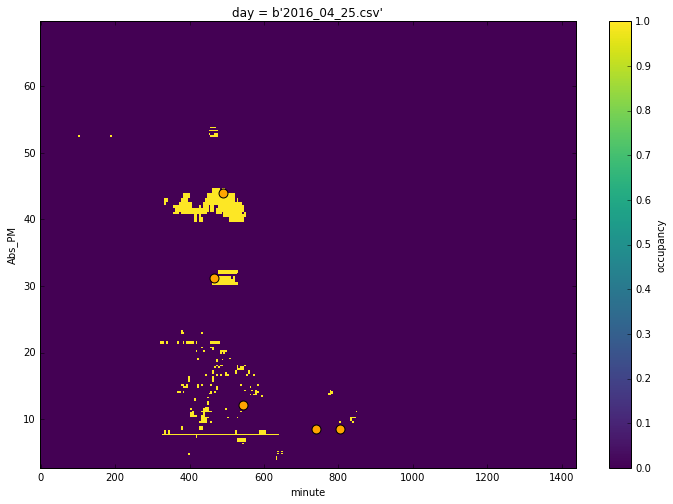

In [142]:
threshold = 0.1

dd = dc > threshold

plt.figure(figsize = (12, 8))
dd.plot(x = "minute", y = "Abs_PM")

plt.scatter(cl["minute"], cl["Abs_PM"], c="orange", s=80)

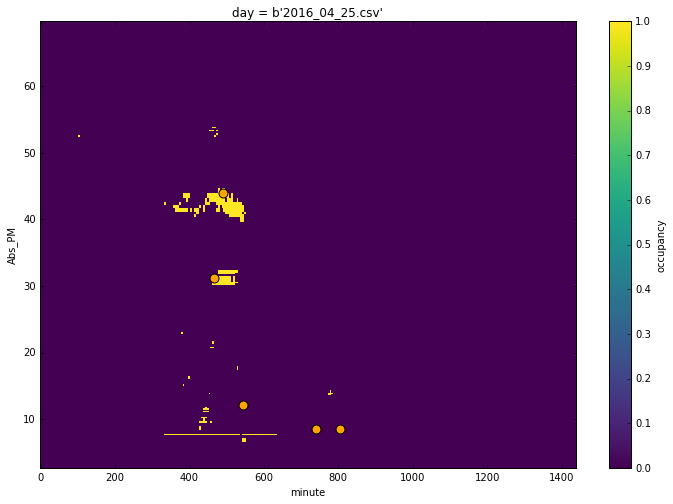

In [145]:
# Does weighting areas of low variance more heavily help eliminate noise? Yes.

dd2 = d2.sel(day = b"2016_04_25.csv") > 1

plt.figure(figsize = (12, 8))
dd2.plot(x = "minute", y = "Abs_PM")

plt.scatter(cl["minute"], cl["Abs_PM"], c="orange", s=80)

In [ ]:
def bbox(daymatrix):
    pass

## Angela's task

Write the code to get the bounding boxes around congestion areas. It should work on `dd` and similar matrices.

Goal is to see an answer like:

```
bbox(dd)
{"day": "04/25", "center_minute": 450, "center_Abs_PM": 45, "minute": 300, "Abs_PM": 7}
{"day": "04/25", "center_minute": 450, "center_Abs_PM": 45, "minute": 100, "Abs_PM": 3}
```

In [129]:
# xarray is just a nice wrapper over the actual matrices
dd2 = dd.data

In [124]:
dd2[10:15, 10:15]

array([[False, False, False, False, False],
       [False, False, False, False, False],
       [False, False, False, False, False],
       [False, False, False, False, False],
       [False, False, False, False, False]], dtype=bool)